In [1]:
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections

**Introduce experience replay.**

In [2]:
Transition = collections.namedtuple('Experience',
                                    field_names=['state', 'action',
                                                 'next_state', 'reward',
                                                 'is_game_on'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size, device = 'cuda'):
        indices = np.random.choice(len(self.memory), batch_size, replace = False)
        
        states, actions, next_states, rewards, isgameon = zip(*[self.memory[idx] 
                                                                for idx in indices])
        
        return torch.Tensor(states).type(torch.float).to(device), \
               torch.Tensor(actions).type(torch.long).to(device), \
               torch.Tensor(next_states).to(device), \
               torch.Tensor(rewards).to(device), torch.tensor(isgameon).to(device)

**Networks definition.**

In [3]:
class fc_nn(nn.Module):
    def __init__(self, Ni, Nh1, Nh2, No = 4):
        super().__init__()
        
        self.fc1 = nn.Linear(Ni, Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)
        
        self.act = nn.ReLU()
        
    def forward(self, x, classification = False, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        out = self.fc3(x)
        
        return out

In [4]:
class conv_nn(nn.Module):
    
    channels = [16, 32, 64]
    kernels = [3, 3, 3]
    strides = [1, 1, 1]
    in_channels = 1
    
    def __init__(self, rows, cols, n_act):
        super().__init__()
        self.rows = rows
        self.cols = cols

        self.conv = nn.Sequential(nn.Conv2d(in_channels = self.in_channels,
                                            out_channels = self.channels[0],
                                            kernel_size = self.kernels[0],
                                            stride = self.strides[0]),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels = self.channels[0],
                                            out_channels = self.channels[1],
                                            kernel_size = self.kernels[1],
                                            stride = self.strides[1]),
                                  nn.ReLU()
                                 )
        
        size_out_conv = self.get_conv_size(rows, cols)
        
        self.linear = nn.Sequential(nn.Linear(size_out_conv, rows*cols*2),
                                    nn.ReLU(),
                                    nn.Linear(rows*cols*2, int(rows*cols/2)),
                                    nn.ReLU(),
                                    nn.Linear(int(rows*cols/2), n_act),
                                   )

    def forward(self, x):
        x = x.view(len(x), self.in_channels, self.rows, self.cols)
        out_conv = self.conv(x).view(len(x),-1)
        out_lin = self.linear(out_conv)
        return out_lin
    
    def get_conv_size(self, x, y):
        out_conv = self.conv(torch.zeros(1,self.in_channels, x, y))
        return int(np.prod(out_conv.size()))

In [5]:
def Qloss(batch, net, gamma=0.99, device="cuda"):
    states, actions, next_states, rewards, _ = batch
    lbatch = len(states)
    state_action_values = net(states.view(lbatch,-1))
    state_action_values = state_action_values.gather(1, actions.unsqueeze(-1))
    state_action_values = state_action_values.squeeze(-1)
    
    next_state_values = net(next_states.view(lbatch, -1))
    next_state_values = next_state_values.max(1)[0]
    
    next_state_values = next_state_values.detach()
    expected_state_action_values = next_state_values * gamma + rewards
    
    return nn.MSELoss()(state_action_values, expected_state_action_values)

**Import the maze and define the environment.**

In [6]:
from environment import MazeEnvironment

maze = np.load('maze_generator/maze.npy')

initial_position = [0,0]
goal = [len(maze)-1, len(maze)-1]

maze_env = MazeEnvironment(maze, initial_position, goal)

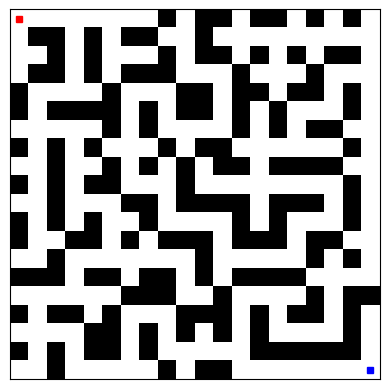

In [7]:
maze_env.draw('maze_20.pdf')

**Define the agent and the buffer for experience replay.**

In [8]:
buffer_capacity = 10000
buffer_start_size = 1000
memory_buffer = ExperienceReplay(buffer_capacity)

In [9]:
from agent import Agent
agent = Agent(maze = maze_env,
              memory_buffer = memory_buffer,
              use_softmax = True
             )

** Define the network.**

In [10]:
net = fc_nn(maze.size, maze.size, maze.size, 4)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [11]:
device = 'cuda'
batch_size = 24
# batch_size = 64
gamma = 0.9

net.to(device)

fc_nn(
  (fc1): Linear(in_features=400, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=4, bias=True)
  (act): ReLU()
)

**Define the epsilon profile and plot the resetting probability.**

[1.         0.99004983 0.98019867 0.97044553 0.96078944 0.95122942
 0.94176453 0.93239382 0.92311635 0.91393119 0.90483742 0.89583414
 0.88692044 0.87809543 0.86935824 0.86070798 0.85214379 0.84366482
 0.83527021 0.82695913 0.81873075 0.81058425 0.8025188  0.7945336
 0.78662786 0.77880078 0.77105159 0.76337949 0.75578374 0.74826357
 0.74081822 0.73344696 0.72614904 0.71892373 0.71177032 0.70468809
 0.69767633 0.69073433 0.68386141 0.67705687 0.67032005 0.66365025
 0.65704682 0.65050909 0.64403642 0.63762815 0.63128365 0.62500227
 0.61878339 0.61262639 0.60653066 0.60049558 0.59452055 0.58860497
 0.58274825 0.57694981 0.57120906 0.56552544 0.55989837 0.55432728
 0.54881164 0.54335087 0.53794444 0.5325918  0.52729242 0.52204578
 0.51685133 0.51170858 0.50661699 0.50157607 0.4965853  0.4916442
 0.48675226 0.48190899 0.47711392 0.47236655 0.46766643 0.46301307
 0.45840601 0.4538448  0.44932896 0.44485807 0.44043165 0.43604929
 0.43171052 0.42741493 0.42316208 0.41895155 0.41478291 0.410655

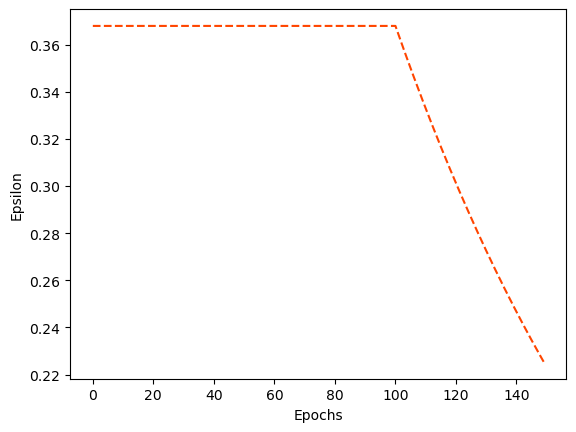

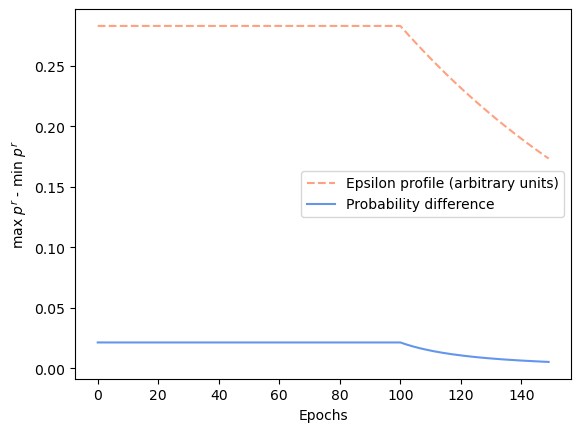

In [12]:
num_epochs = 150

cutoff = 100
epsilon = np.exp(-np.arange(num_epochs)/(cutoff))
print(epsilon)
epsilon[epsilon > epsilon[100*int(num_epochs/cutoff)]] = epsilon[100*int(num_epochs/cutoff)]
plt.plot(epsilon, color = 'orangered', ls = '--')
plt.xlabel('Epochs')
plt.ylabel('Epsilon')
plt.savefig('epsilon_profile.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

mp = []
mpm = []
reg = 200
for e in epsilon:
    a = agent.env.reset_policy(e)
    mp.append(np.min(a))
    mpm.append(np.max(a))

plt.plot(epsilon/1.3, color = 'orangered', ls = '--', alpha = 0.5,
         label= 'Epsilon profile (arbitrary units)')

plt.plot(np.array(mpm)-np.array(mp), label = 'Probability difference', color = 'cornflowerblue')
plt.xlabel('Epochs')
plt.ylabel(r'max $p^r$ - min $p^r$')
plt.legend()
plt.savefig('reset_policy.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

**Training the network.**

In [13]:
loss_log = []
best_loss = 1e5

running_loss = 0

for epoch in range(num_epochs):
    loss = 0
    counter = 0
    eps = epsilon[epoch]
    
    agent.isgameon = True
    _ = agent.env.reset(eps)
    
    while agent.isgameon:
        agent.make_a_move(net, eps)
        counter += 1
        
        if len(agent.buffer) < buffer_start_size:
            continue
            
        optimizer.zero_grad()
        batch = agent.buffer.sample(batch_size, device = device)
        # print(f"length of batch is {len(batch)}")
        states, actions, next_states, rewards, _ = batch
        # print(f"this is the state ({len(states[0])} x {len(states[0][0])}): {states[0]}")
        # print(f"these are the actions ({len(actions)}): {actions}")
        # print(f"these are the next states ({len(next_states[0])} x {len(next_states[0][0])}): {next_states[0]}")
        # print(f"the rewards ({len(rewards)} x {len(rewards)}) are {rewards}")
        
        loss_t = Qloss(batch, net, gamma = gamma, device = device)
        loss_t.backward()
        optimizer.step()
        
        loss += loss_t.item()
    
    if (agent.env.current_position == agent.env.goal).all():
        result = 'won'
    else:
        result = 'lost'
    
    if epoch%1000 == 0:
        agent.plot_policy_map(net, 'sol_epoch_'+str(epoch)+'.pdf', [0.35,-0.3])
    
    loss_log.append(loss)
    
    if (epoch > 2000):
        running_loss = np.mean(loss_log[-50:])
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(net.state_dict(), "best.torch")
            estop = epoch
    
    print('Epoch', epoch, '(number of moves ' + str(counter) + ')')
    print('Game', result)
    print('[' + '#'*(100-int(100*(1 - epoch/num_epochs))) +
          ' '*int(100*(1 - epoch/num_epochs)) + ']')
    print('\t Average loss: ' + f'{loss:.5f}')
    if (epoch > 2000):
        print('\t Best average loss of the last 50 epochs: ' + f'{best_loss:.5f}' + ', achieved at epoch', estop)
    clear_output(wait = True)

Epoch 149 (number of moves 133)
Game won
[####################################################################################################]
	 Average loss: 0.25811


In [19]:
torch.save(net.state_dict(), "net.torch")

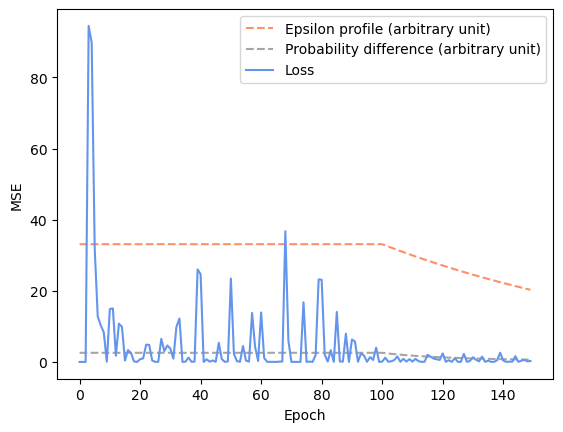

In [20]:
plt.plot(epsilon*90, alpha = 0.6, ls = '--', label = 'Epsilon profile (arbitrary unit)', color = 'orangered')
plt.plot((np.array(mpm)-np.array(mp))*120, alpha = 0.6, ls = '--',
         label = 'Probability difference (arbitrary unit)', color = 'dimgray')
plt.plot(loss_log, label = 'Loss', color = 'cornflowerblue')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.savefig('loss.pdf', dpi = 300, bbox_inches='tight')
plt.show()

**Show the maze solution and the policy learnt.**

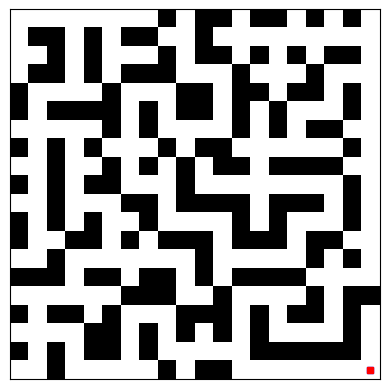

In [21]:
net.eval()
agent.isgameon = True
agent.use_softmax = False
_ = agent.env.reset(0)
while agent.isgameon:
    agent.make_a_move(net, 0)
    agent.env.draw('')
    clear_output(wait = True)

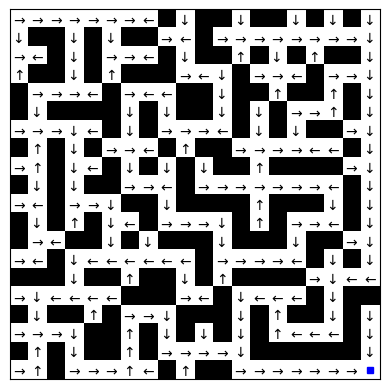

In [22]:
agent.plot_policy_map(net, 'solution.pdf', [0.35,-0.3])

In [24]:
best_net = copy.deepcopy(net)
best_net.load_state_dict(torch.load('net.torch'))

<All keys matched successfully>

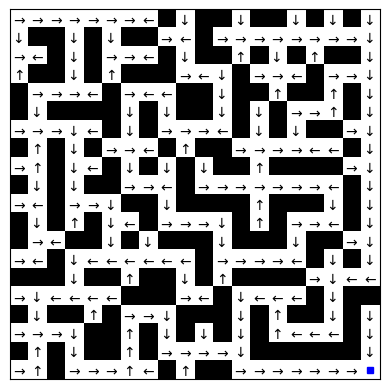

In [25]:
agent.plot_policy_map(best_net, 'solution_best.pdf', [0.35,-0.3])